In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def ma(df, periods, ema=True, on='Close'):
    """Calculate the Moving Average (MA) or Exponential Moving Average (EMA) for a given DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - periods: Number of periods to consider for MA or EMA
    - ema: Boolean to decide if EMA should be calculated. If False, MA is calculated.
    - on: Column name on which the moving average is to be calculated.

    Returns:
    - A Series containing the calculated MA or EMA values.
    """
    if ema:
        return df[on].ewm(span=periods, adjust=False).mean()
    return df[on].rolling(window=periods).mean()


def check_if_higher(df, columns):
    """Check if values in the first column are greater than values in the second column.

    Parameters:
    - df: DataFrame containing the data
    - columns: A list of two column names.

    Returns:
    - A Boolean Series indicating whether values in the first column are greater than values in the second column.
    """
    return df[columns].iloc[:, 0] > df[columns].iloc[:, 1]


def data_prepare(df, start='2020-08-1', to='2023-07-31'):
    """Prepare data by adding EMA and MA columns to the DataFrame based on specified start and end dates.

    Parameters:
    - df: DataFrame containing the data
    - start: Start date for the data range
    - to: End date for the data range

    Returns:
    - A DataFrame filtered by the specified date range and added with EMA and MA columns.
    """
    df['EMA20'] = ma(df, 20)
    df['EMA200'] = ma(df, 200)
    df['MA20_Vol'] = ma(df, 20, ema=False, on='Volume')
    return df[(df['Date'] >= start) & (df['Date'] <=to)]


def condition_define(df):
    """Define various conditions and add them as new columns to the DataFrame.

    Parameters:
    - df: DataFrame containing the data

    Note: This function modifies the input DataFrame in-place.
    """
    df['Close > EMA20'] = check_if_higher(df, ['Close', 'EMA20'])
    df['EMA20 > EMA200'] = check_if_higher(df, ['EMA20', 'EMA200'])
    df['Vol > MA20'] = check_if_higher(df, ['Volume', 'MA20_Vol'])
    df['Close > EMA20 PreDay'] = df['Close > EMA20'].shift()
    df['Pre Close'] = df['Close'].shift()
    df['Cross under 20'] = (df['Close > EMA20'] == False) & (df['Close > EMA20 PreDay'])

    # Calculate days to breakeven and maximum drawdown after crossing under 20
    df['Day to breakeven'] = 0
    df['Maxium drawdown'] = 0
    close_lower = df[df['Cross under 20']].index.tolist()
    for i in close_lower:
        day_of_recovery = (df['Close'] >= df['Pre Close'][i]).iloc[i:].argmax()
        if day_of_recovery > 0:
            df['Day to breakeven'][i] = day_of_recovery
            df['Maxium drawdown'][i] = (df['Low'].iloc[i+1:i+day_of_recovery+1].min() - df['Close'][i])/df['Close'][i]

    # Calculate carrying loss for stocks that haven't recovered
    df['Carrying loss'] = 0
    no_recover = df[(df['Day to breakeven'] == 0) & (df['Cross under 20'] > 0)].index.to_list()
    if no_recover:
        last = len(df)
        df['Carrying loss'][no_recover] = (df['Close'][last-1] - df['Close'][no_recover]) / df['Close'][no_recover]


def adding_label(df):
    """Add stock and sector labels to the DataFrame.

    Parameters:
    - df: DataFrame containing the data

    Note: stock_list variable needs to be defined elsewhere in the script.
    """
    df[['Stock', 'Sector']] = [stock_list.iloc[s]['Ticker'], stock_list.iloc[s]['Sector']]


def change_label(df, columns='', true_value='', false_value=''):
    """Change the labels of boolean columns to specific string values.

    Parameters:
    - df: DataFrame containing the data
    - columns: Name of the column to change labels
    - true_value: String value to replace True values
    - false_value: String value to replace False values

    Note: This function modifies the input DataFrame in-place.
    """
    df[columns] = df[columns].replace({True: true_value, False: false_value})


In [ ]:
# Read the stock list from the CSV file into a pandas DataFrame with 'Ticker' and 'Sector
stock_list = pd.read_csv(Path)
data_for_analysis = []
# Loop over each stock in the stock_list
for s in range(len(stock_list)):
    # Print the ticker of the current stock for tracking
    print(stock_list.iloc[s]['Ticker'])

    # Fetch the data for the current stock using yfinance's Ticker method
    stock_data = yf.Ticker(stock_list.iloc[s]['Ticker'])
    price_data = stock_data.history(period='max').reset_index()

    # Add labels like stock ticker and sector, and columns to the price data
    price_data = data_prepare(price_data).reset_index(drop=True)
    condition_define(price_data)
    adding_label(price_data)

    # Append the processed price data to the data_for_analysis list for future analysis
    data_for_analysis.append(price_data)


In [ ]:
# Initialize a list to store the number of trading days for each stock

trading_day_list = []
# Filter out stocks that have fewer than 252 trading days
for d in data_for_analysis:
    trading_day_list.append(len(d))
stock_over1year = pd.Series(data_for_analysis)[pd.Series(trading_day_list) > 252].tolist()


In [ ]:
# Concatenate (join together) the list of DataFrames containing stock data into a single DataFrame
stock_collected = pd.concat(stock_over1year)
stock_collected = stock_collected.reset_index(drop=True)

In [7]:
related_col = ['Sector', 'EMA20 > EMA200', 'Vol > MA20', 'Cross under 20', 'Day to breakeven', 'Maxium drawdown', 'Carrying loss']

In [11]:
# Create a deep copy of the stock_collected DataFrame
stock_change_label = stock_collected.copy()

# Change the labels in the 'EMA20 > EMA200' column:
change_label(stock_change_label, 'EMA20 > EMA200', 'Uptrend', 'Downtrend')

# Change the labels in the 'Vol > MA20' column:
change_label(stock_change_label, 'Vol > MA20', 'High vol', 'Low vol')


In [12]:
# Group the stock_collected DataFrame by the 'Sector' column.
sector_group = stock_collected.groupby('Sector')

# Group the stock_change_label DataFrame by the 'EMA20 > EMA200' column.
ema200_group = stock_change_label.groupby('EMA20 > EMA200')

# Group the stock_change_label DataFrame by the 'Vol > MA20' column.
vol_group = stock_change_label.groupby('Vol > MA20')


In [18]:
sector_group['Stock'].nunique()

Sector
Commercial Services       22
Communications             3
Consumer Durables         14
Consumer Non-Durables     13
Consumer Services         20
Distribution Services      7
Electronic Technology     32
Energy Minerals           10
Finance                   87
Health Services            9
Health Technology         92
Industrial Services       12
Miscellaneous              3
Non-Energy Minerals        9
Process Industries        16
Producer Manufacturing    27
Retail Trade              16
Technology Services       51
Transportation            12
Utilities                 10
Name: Stock, dtype: int64

## Overall piture

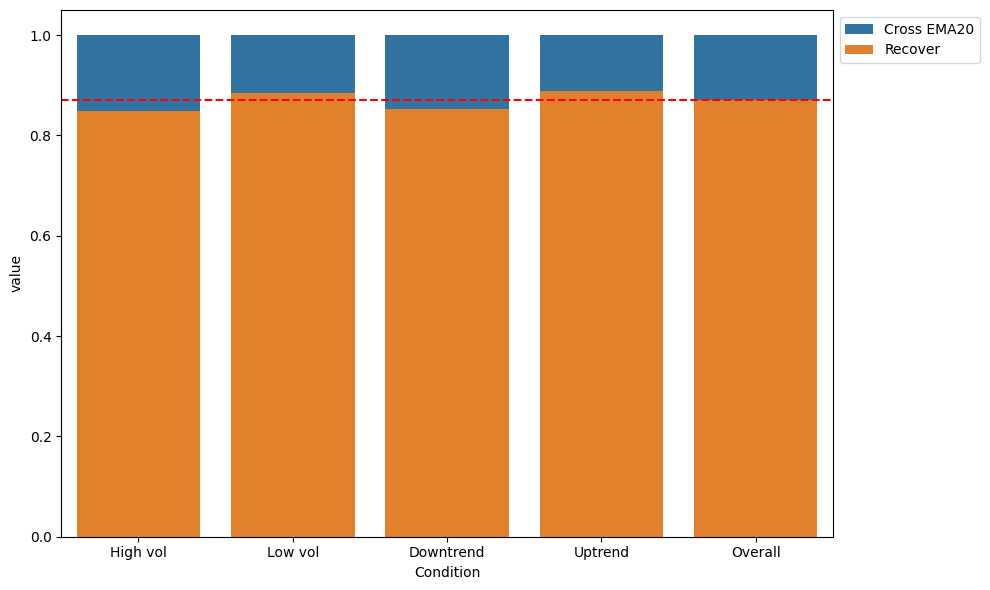

In [ ]:
plt.figure(figsize=(10, 6), )

recover_data = ema200_group[['Cross under 20','Day to breakeven']].agg(stats_of_cross)
overall = stock_collected[['Cross under 20','Day to breakeven']].agg(stats_of_cross)
recover_data.loc['Overall'] = overall
voldata = vol_group[['Cross under 20','Day to breakeven',]].agg(stats_of_cross)
recover_data = pd.concat([voldata, recover_data])
recover_data = recover_data.div(recover_data['Cross under 20'], axis=0)
recover_data = recover_data.reset_index()
recover_data.columns = ['Condition', 'Cross EMA20', 'Recover']
recover_data_long = recover_data.melt(id_vars='Condition', value_vars=recover_data.columns[1:])
sns.barplot(recover_data_long, x='Condition', y="value", hue="variable", dodge=False)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axhline(y=recover_data[recover_data['Condition']=='Overall']['Recover'].values, color='r', linestyle='--')
plt.tight_layout()
plt.show()


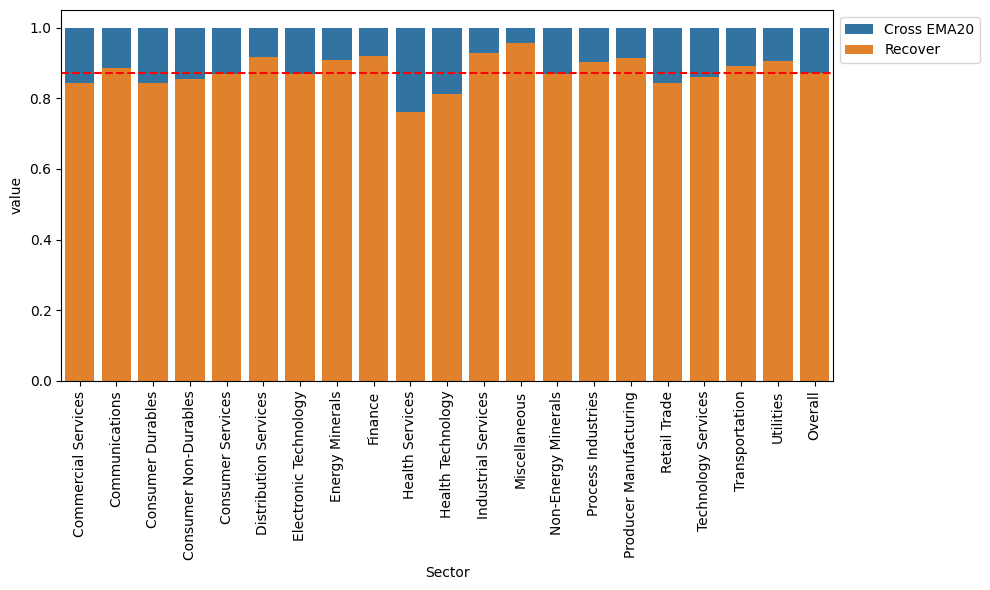

In [ ]:
plt.figure(figsize=(10, 6))

sector_data = sector_group[['Cross under 20','Day to breakeven']].agg(stats_of_cross)
overall = stock_collected[['Cross under 20','Day to breakeven']].agg(stats_of_cross)
sector_data.loc['Overall'] = overall
sector_data = sector_data.div(sector_data['Cross under 20'], axis=0)
sector_data = sector_data.reset_index()
sector_data.columns = ['Sector', 'Cross EMA20', 'Recover']
sector_data_long = sector_data.melt(id_vars='Sector', value_vars=sector_data.columns[1:])
sns.barplot(sector_data_long, x='Sector', y="value", hue="variable", dodge=False)


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.axhline(y=sector_data[sector_data['Sector']=='Overall']['Recover'].values, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Day to breakeven

<Axes: xlabel='Day to breakeven'>

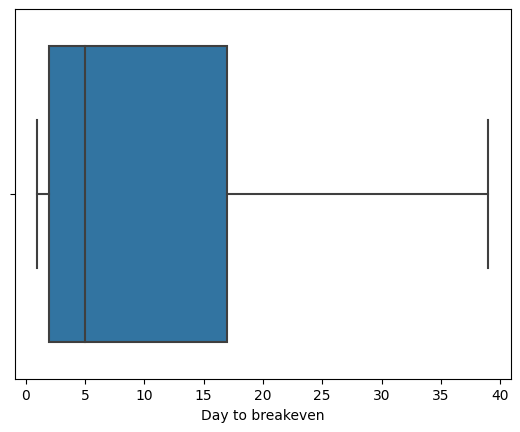

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Day to breakeven', showfliers=False)

<Axes: xlabel='Day to breakeven', ylabel='Vol > MA20'>

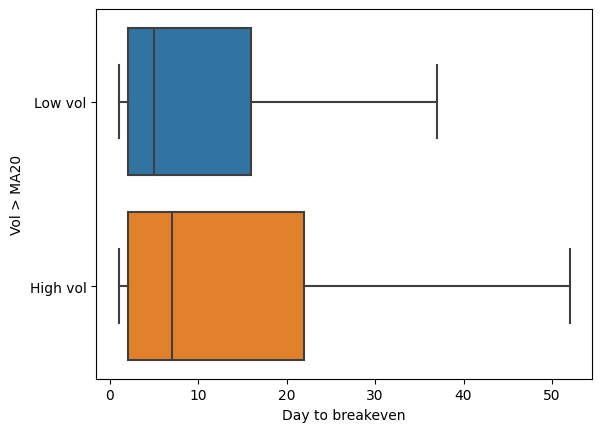

In [ ]:

sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Day to breakeven', y='Vol > MA20', showfliers=False)


<Axes: xlabel='Day to breakeven', ylabel='EMA20 > EMA200'>

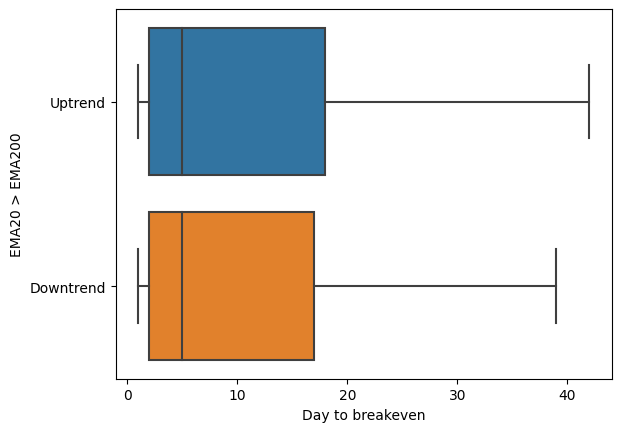

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Day to breakeven', y='EMA20 > EMA200', showfliers=False)

<Axes: xlabel='Day to breakeven', ylabel='Sector'>

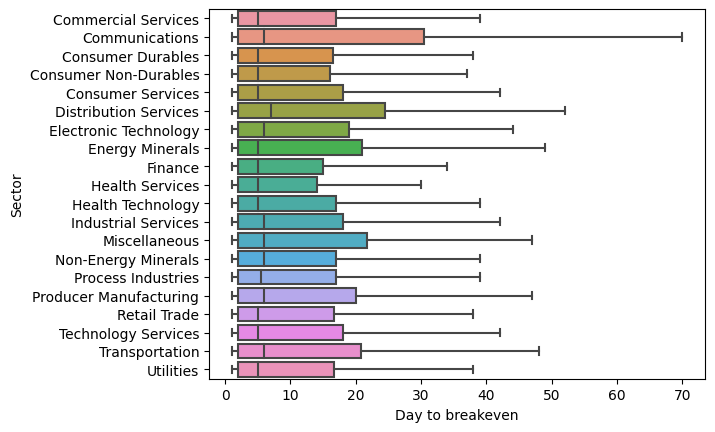

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Day to breakeven', y="Sector", showfliers=False)

## Maximun drawback

<Axes: xlabel='Maxium drawdown'>

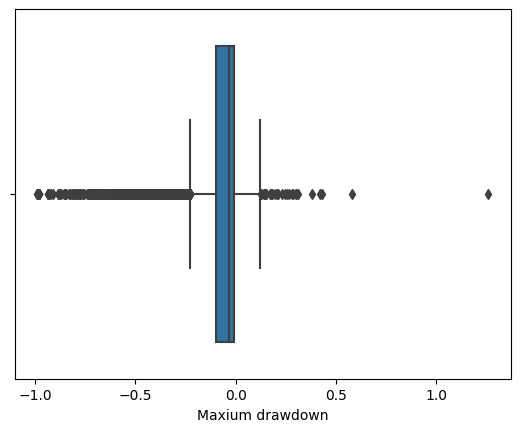

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown')

<Axes: xlabel='Maxium drawdown', ylabel='Vol > MA20'>

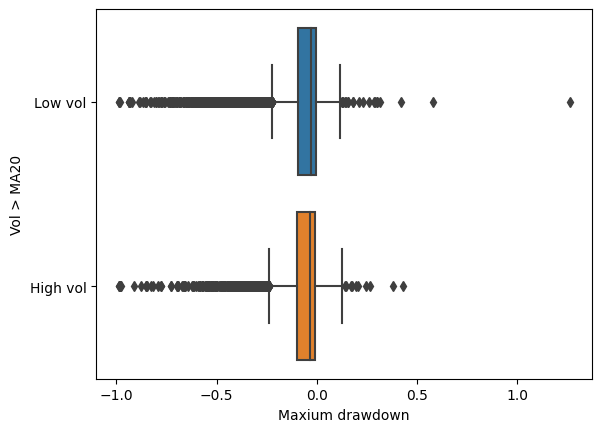

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='Vol > MA20')

<Axes: xlabel='Maxium drawdown', ylabel='EMA20 > EMA200'>

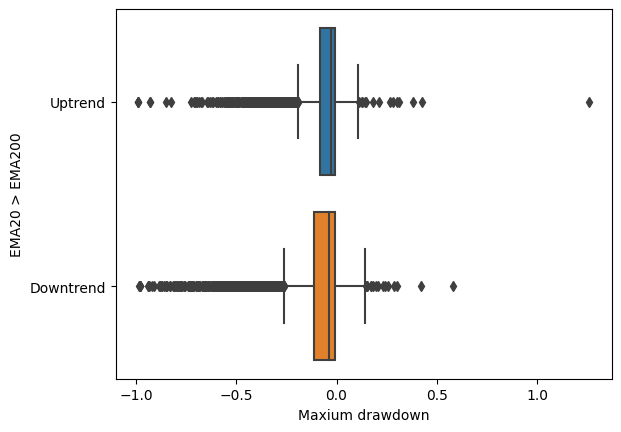

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='EMA20 > EMA200')

<Axes: xlabel='Maxium drawdown', ylabel='Sector'>

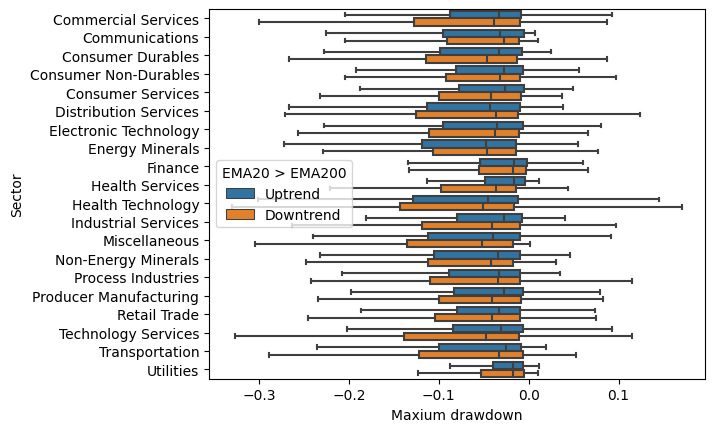

In [ ]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='Sector', hue='EMA20 > EMA200', showfliers=False)

## Breakeven day in relation to Maximum drawdown

In [ ]:
bins = [1, 5,10,20,30,40,50,100,200, 600]
stock_change_label['Breakeven'] = pd.cut(stock_collected['Day to breakeven'], bins=bins)

<Axes: xlabel='Maxium drawdown', ylabel='Breakeven'>

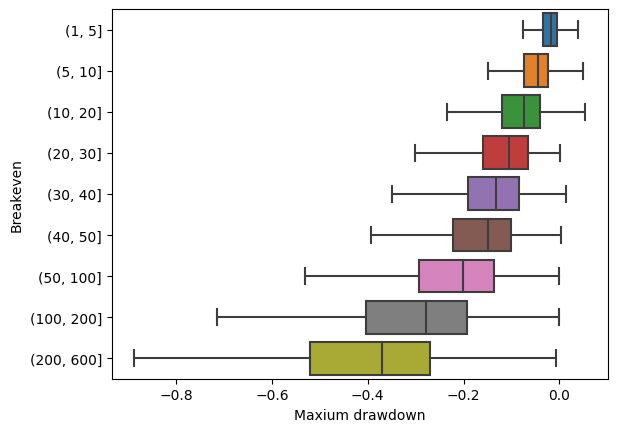

In [24]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='Breakeven', showfliers=False)

<Axes: xlabel='Maxium drawdown', ylabel='Breakeven'>

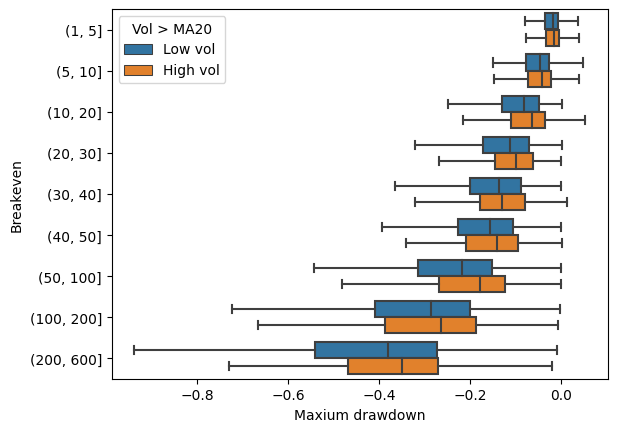

In [22]:

sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='Breakeven', hue='Vol > MA20', showfliers=False)

<Axes: xlabel='Maxium drawdown', ylabel='Breakeven'>

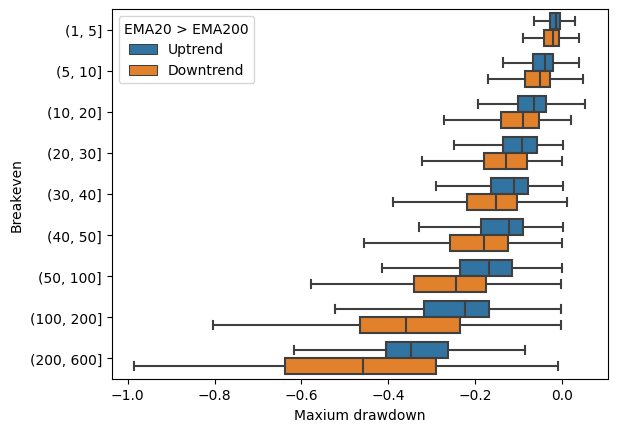

In [23]:
sns.boxplot(data=stock_change_label[stock_change_label['Day to breakeven']>0], x='Maxium drawdown', y='Breakeven', hue='EMA20 > EMA200', showfliers=False)

## What happen if not protect from the downside

In [28]:
carrying_loss = stock_change_label[(stock_change_label['Cross under 20'] > 0) & (stock_change_label['Day to breakeven']==0)]

<Axes: xlabel='Carrying loss'>

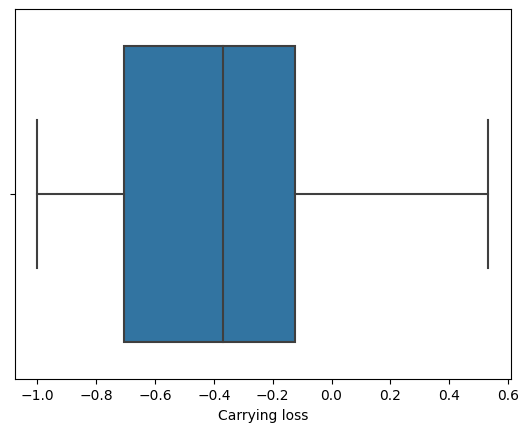

In [31]:
sns.boxplot(data=carrying_loss, x='Carrying loss')

<Axes: xlabel='Carrying loss', ylabel='EMA20 > EMA200'>

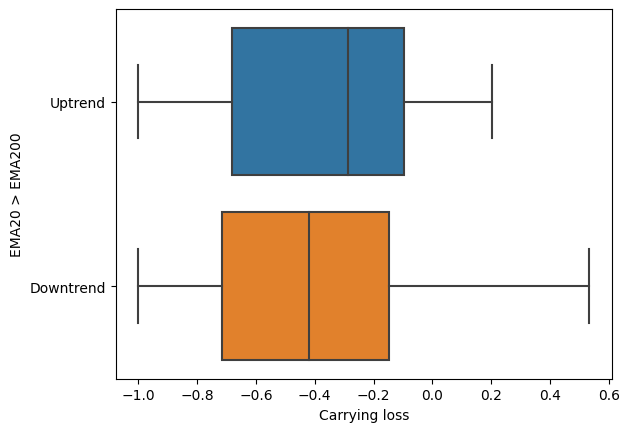

In [33]:
sns.boxplot(carrying_loss, x='Carrying loss', y='EMA20 > EMA200')

<Axes: xlabel='Carrying loss', ylabel='Vol > MA20'>

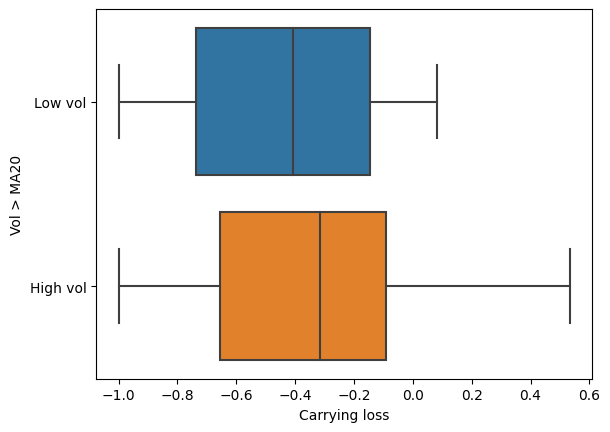

In [34]:
sns.boxplot(carrying_loss, x='Carrying loss', y='Vol > MA20')

## Appendix

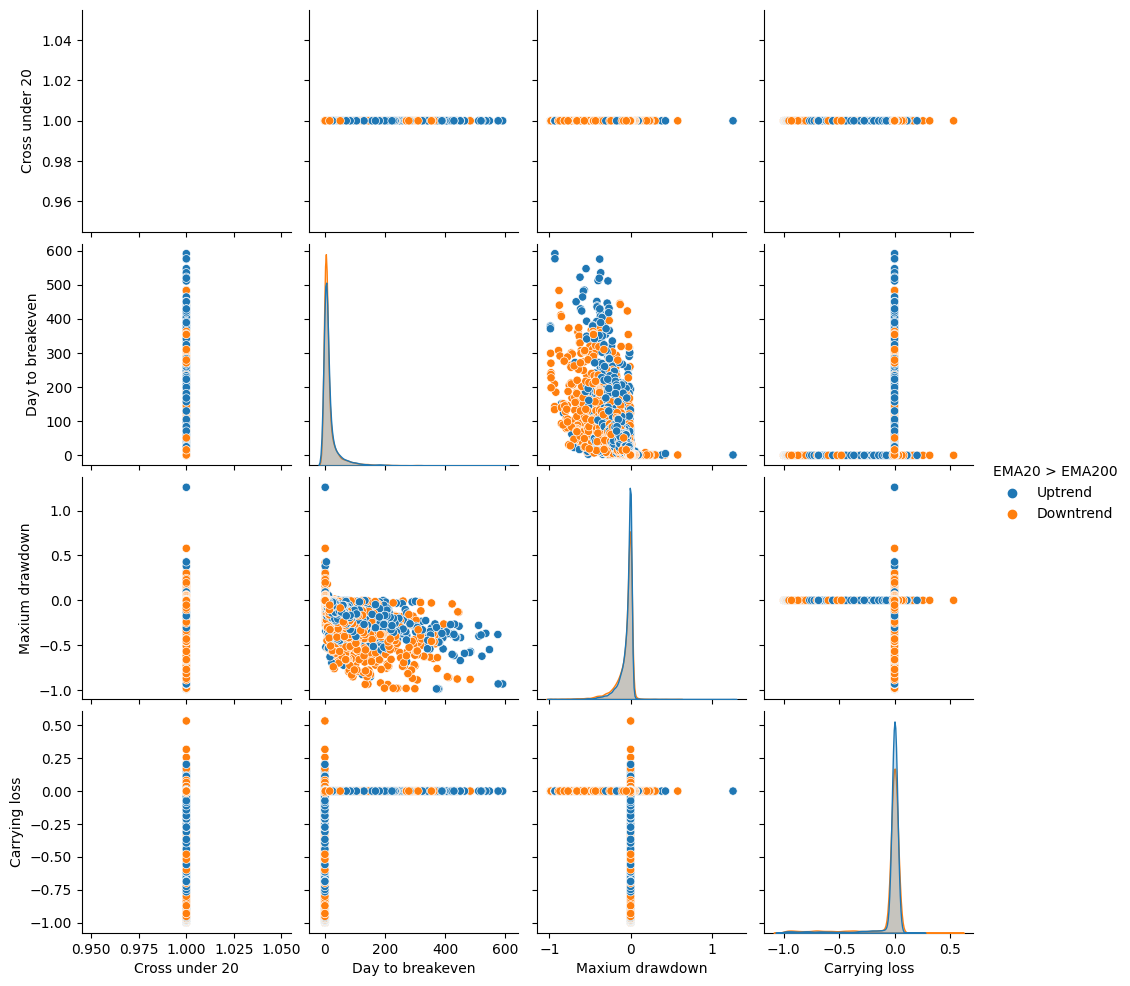

In [ ]:
sns.pairplot(stock_chang_label[stock_chang_label['Cross under 20']>0][related_col], hue='EMA20 > EMA200')

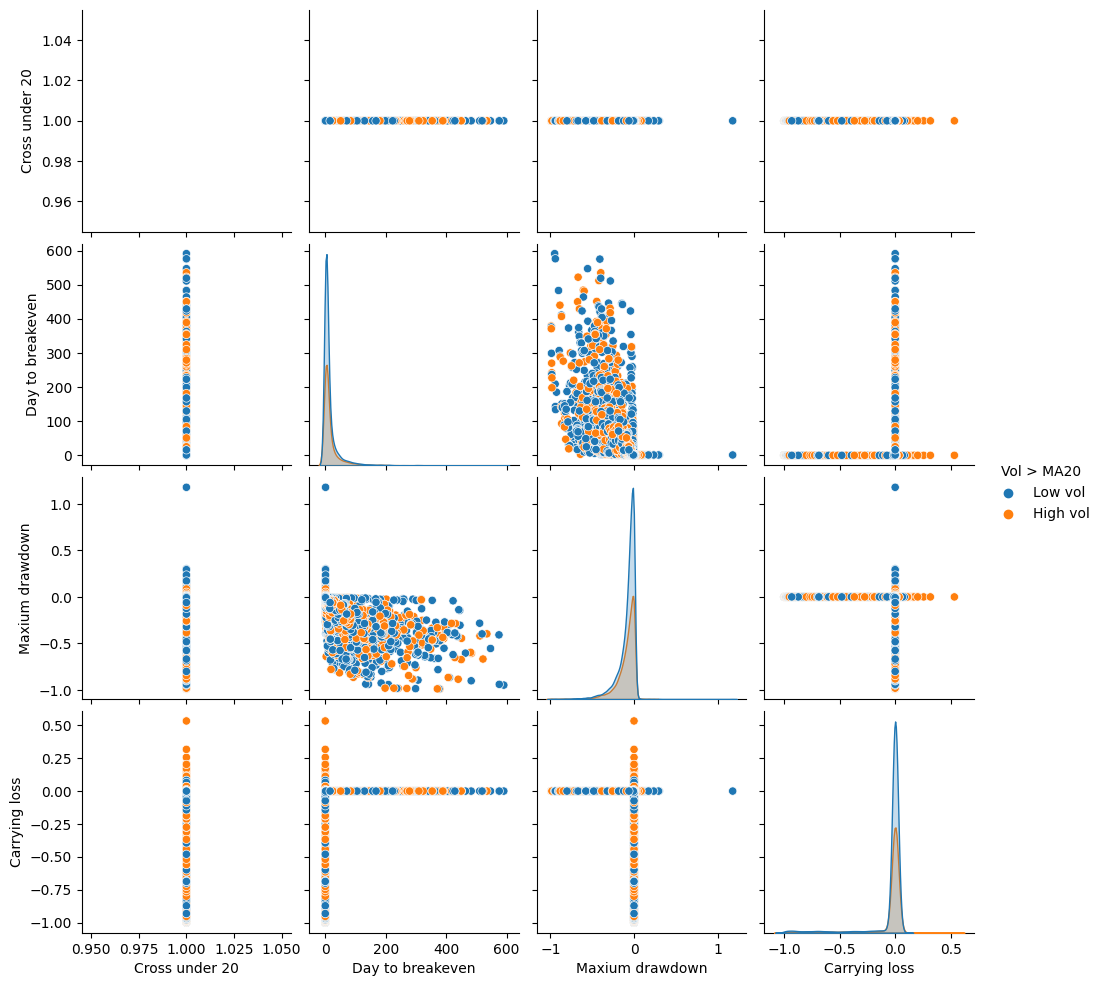

In [ ]:
sns.pairplot(stock_chang_label[stock_chang_label['Cross under 20']>0][related_col], hue='Vol > MA20')

In [ ]:
def stats_of_cross(arr):
    return arr[arr>0].size
stats_of_recovery = ('mean', 'std', 'max','min')

In [ ]:
sector_recoverd_group = stock_collected[stock_collected['Day to breakeven']>0].groupby('Sector')
ema200_recoverd_group = stock_collected[stock_collected['Day to breakeven']>0].groupby('EMA20 > EMA200')
vol_recoverd_group = stock_collected[stock_collected['Day to breakeven']>0].groupby('Vol > MA20')

sector_unrecoverd_group = stock_collected[(stock_collected['Day to breakeven']==0) & (stock_collected['Cross under 20']>0)].groupby('Sector')
ema200_unrecoverd_group = stock_collected[(stock_collected['Day to breakeven']==0) & (stock_collected['Cross under 20']>0)].groupby('EMA20 > EMA200')
vol_unrecoverd_group = stock_collected[(stock_collected['Day to breakeven']==0) & (stock_collected['Cross under 20']>0)].groupby('Vol > MA20')

In [ ]:
sector_recoverd_group[['Day to breakeven', 'Maxium drawdown']].agg(stats_of_recovery)

Day to breakeven                     Maxium drawdown  \
                                   mean        std  max min            mean   
Sector                                                                        
Commercial Services           17.768362  34.765333  323   1       -0.078211   
Communications                34.967742  82.514442  512   1       -0.068517   
Consumer Durables             16.504817  32.924499  353   1       -0.082333   
Consumer Non-Durables         19.190826  44.839914  446   1       -0.066329   
Consumer Services             18.469534  39.116200  547   1       -0.060550   
Distribution Services         25.881119  52.217560  392   1       -0.079406   
Electronic Technology         22.359009  46.514560  575   1       -0.075507   
Energy Minerals               20.455399  38.506521  274   1       -0.087380   
Finance                       17.822310  39.223156  445   1       -0.040719   
Health Services               15.954704  28.425858  205   1       -0.062351   
Health Technology             21.215979  46.076325  591   1       -0.102962   
Industrial Services           19.211832  41.389755  511   1       -0.068703   
Miscellaneous                 33.930380  79.824818  522   1       -0.092464   
Non-Energy Minerals           24.322165  62.373608  451   1       -0.078059   
Process Industries            19.970027  38.204114  392   1       -0.072548   
Producer Manufacturing        23.946192  55.275865  519   1       -0.066587   
Retail Trade                  18.114085  33.420849  238   1       -0.064544   
Technology Services           20.543307  42.605774  381   1       -0.084069   
Transportation                25.601215  52.926035  389   1       -0.073023   
Utilities                     16.580786  29.517918  223   1       -0.035737   

                                                      
                             std       max       min  
Sector                                                
Commercial Services     0.112459  0.300000 -0.692523  
Communications          0.092433  0.010427 -0.400387  
Consumer Durables       0.122732  0.086614 -0.723849  
Consumer Non-Durables   0.101023  0.097561 -0.571142  
Consumer Services       0.081176  0.206563 -0.549093  
Distribution Services   0.105379  0.123596 -0.639245  
Electronic Technology   0.104823  0.266667 -0.607843  
Energy Minerals         0.113799  0.076923 -0.804734  
Finance                 0.065771  0.312312 -0.761446  
Health Services         0.108925  0.044177 -0.794688  
Health Technology       0.151294  1.260204 -0.988475  
Industrial Services     0.104451  0.243781 -0.741497  
Miscellaneous           0.129448  0.092105 -0.623077  
Non-Energy Minerals     0.115833  0.045638 -0.852083  
Process Industries      0.100044  0.114456 -0.682778  
Producer Manufacturing  0.099530  0.230312 -0.802198  
Retail Trade            0.080525  0.196816 -0.407622  
Technology Services     0.118380  0.115171 -0.887316  
Transportation          0.104589  0.053101 -0.770115  
Utilities               0.048776  0.011647 -0.305335

In [ ]:
ema200_recoverd_group[['Day to breakeven', 'Maxium drawdown']].agg(stats_of_recovery)

Day to breakeven                     Maxium drawdown            \
                           mean        std  max min            mean       std   
EMA20 > EMA200                                                                  
False                 19.591736  40.518934  483   1       -0.083344  0.124734   
True                  20.961511  47.033633  591   1       -0.060945  0.093197   

                                    
                     max       min  
EMA20 > EMA200                      
False           0.579545 -0.985217  
True            1.260204 -0.988475

In [ ]:
vol_recoverd_group[['Day to breakeven', 'Maxium drawdown']].agg(stats_of_recovery)

Day to breakeven                     Maxium drawdown            \
                       mean        std  max min            mean       std   
Vol > MA20                                                                  
False             18.800016  42.585741  591   1       -0.070699  0.110998   
True              22.956771  46.235758  535   1       -0.074021  0.109056   

                                
                 max       min  
Vol > MA20                      
False       1.260204 -0.988475  
True        0.428571 -0.988455

In [ ]:
stock_collected[stock_collected['Day to breakeven']>0][['Day to breakeven', 'Maxium drawdown']].agg(stats_of_recovery)

,Day to breakeven,Maxium drawdown
mean,20.292108,-0.071892
std,43.974892,0.110314
max,591.000000,1.260204
min,1.000000,-0.988475


In [ ]:
stock_collected[(stock_collected['Day to breakeven']==0) & (stock_collected['Cross under 20']>0)]['Carrying loss'].agg(stats_of_recovery)

mean   -0.417787
std     0.323455
max     0.532880
min    -0.999736
Name: Carrying loss, dtype: float64

In [ ]:
sector_unrecoverd_group['Carrying loss'].agg(stats_of_recovery)

,mean,std,max,min
Sector,,,,
Commercial Services,-0.428256,0.314660,0.050109,-0.980149
Communications,-0.233134,0.244748,0.030000,-0.616387
Consumer Durables,-0.440834,0.348494,0.188119,-0.996794
Consumer Non-Durables,-0.435191,0.327176,0.099237,-0.916579
Consumer Services,-0.321840,0.321842,0.162812,-0.999736
Distribution Services,-0.455106,0.372372,0.015780,-0.975768
Electronic Technology,-0.384598,0.334444,0.165287,-0.992364
Energy Minerals,-0.308448,0.346341,0.064441,-0.989506
Finance,-0.264904,0.265874,0.209363,-0.986000


In [ ]:
ema200_unrecoverd_group['Carrying loss'].agg(stats_of_recovery)

,mean,std,max,min
EMA20 > EMA200,,,,
False,-0.442809,0.320451,0.532880,-0.999539
True,-0.385085,0.324571,0.202644,-0.999736


In [ ]:
vol_unrecoverd_group['Carrying loss'].agg(stats_of_recovery)

,mean,std,max,min
Vol > MA20,,,,
False,-0.448173,0.323919,0.081482,-0.999736
True,-0.377624,0.318550,0.532880,-0.999726


In [ ]:
stock_collected[['Close', 'Close > EMA20','Cross under 20','Day to breakeven', 'Maxium drawdown']].agg(stats_of_cross)

Close               327589
Close > EMA20       159710
Cross under 20       22348
Day to breakeven     19462
Maxium drawdown       2312
dtype: int64

In [ ]:
stock_chang_label[stock_chang_label['Day to breakeven']>200]

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,...,Vol > MA20,Close > EMA20 PreDay,Pre Close,Cross under 20,Day to breakeven,Maxium drawdown,Carrying loss,Stock,Sector,breakeven
2271,2271,2021-11-26 00:00:00-05:00,116.432767,117.698136,109.449468,110.115448,211200,0.0,0.0,114.613333,...,High vol,True,119.011086,True,306,-0.259201,0.0,NSP,Commercial Services,"(200, 600]"
2298,2298,2022-01-05 00:00:00-05:00,114.673075,114.673075,109.522502,109.668274,108400,0.0,0.0,111.909151,...,Low vol,True,114.158020,True,206,-0.256181,0.0,NSP,Commercial Services,"(200, 600]"
3159,3159,2022-06-10 00:00:00-04:00,65.046366,65.144157,64.058746,64.058746,90900,0.0,0.0,65.782399,...,Low vol,True,66.131775,True,275,-0.238655,0.0,KFRC,Commercial Services,"(200, 600]"
6815,6815,2021-10-27 00:00:00-04:00,191.080002,193.539993,183.820007,184.169998,397500,0.0,0.0,186.823945,...,High vol,True,192.369995,True,323,-0.332084,0.0,WEX,Commercial Services,"(200, 600]"
6923,6923,2022-04-01 00:00:00-04:00,178.330002,179.130005,171.100006,172.529999,529600,0.0,0.0,172.585620,...,High vol,True,178.449997,True,202,-0.275488,0.0,WEX,Commercial Services,"(200, 600]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318197,318197,2022-03-01 00:00:00-05:00,8.560000,8.618000,8.260000,8.260000,16800,0.0,0.0,8.315618,...,High vol,True,8.570000,True,279,-0.158596,0.0,PATI,Transportation,"(200, 600]"
319827,319827,2022-08-26 00:00:00-04:00,231.243852,231.806114,223.886009,224.196228,1728800,0.0,0.0,226.319698,...,Low vol,True,231.757645,True,228,-0.201222,0.0,UNP,Transportation,"(200, 600]"
319838,319838,2022-09-13 00:00:00-04:00,224.365462,226.051992,219.881087,220.602478,2378300,0.0,0.0,224.039334,...,High vol,True,228.274689,True,217,-0.188210,0.0,UNP,Transportation,"(200, 600]"
320253,320253,2021-05-11 00:00:00-04:00,42.422004,42.422004,41.542141,41.856377,319300,0.0,0.0,41.872948,...,Low vol,True,42.511787,True,206,-0.174963,0.0,AVA,Utilities,"(200, 600]"
